In [6]:
from zonal_stats_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import rasterio
import rioxarray

# disable window width for better printing of numpy arrays
np.set_printoptions(linewidth=np.inf)

In [ ]:
# define the hyperbolic function with vertical asymptote horizontal asymptote at 1
# this function is used to calculate the scale factor using the polygon area to grid cell area ratio
def hyp_function(x, m, b, c, h):
    """
    Hyperbolic function with vertical asymptote at x=c and horizontal asymptote at y=h
    Arguments:
        x: ratio of polygon area to grid cell area
        m: slope of the line
        b: y-intercept of the line
        c: x-coordinate of the vertical asymptote
        h: y-coordinate of the horizontal asymptote
    Returns:
        y: scale factor
    """
    y = (m * x + b) / (x - c) + h
    return y


m = 0
b = 350
c = -24
h = 1

In [7]:
# set parameters

# grid names + grid cell sizes (m) to match datasets
grid_names = ["771m", "1km", "2km", "12km", "20km"]
grid_sizes = [771, 1000, 2000, 12000, 20000]

# get demo polygons dict (all HUC10 or HUC12 polygons within a bounding box defined by a HUC8)
huc8_id = "19080404"
polygons, bbox = get_huc10_and_huc12_polygons_within_huc8(huc8_id)

Found 353 polygons within the HUC8 19080404 bounding box.
Mean area of 63 HUC10 polygons: 660.17 km²
Mean area of 289 HUC12 polygons: 108.65 km²


In [8]:
# function to load tif and convert to xarray dataset
# rename the raster band loaded as variable to "data"
def load_tif_to_xarray(tif_path):
    ds = rioxarray.open_rasterio(tif_path, band_as_variable=True, mask_and_scale=True)
    ds = ds.rename({"band_1": "data"})
    return ds

In [9]:
# sources
# one tif was chosen per source and copied to the data directory
# except for the 20km WRF, which is already a netcdf file

# Historical Monthly and Derived Precipitation Products - 771m CRU TS
# https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/badab6be-5a29-4fae-b9de-5eff6f48702e

# Historical Monthly Precipitation - 1 km CRU TS
# https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/249d3c55-06b0-4c54-86c2-0281c2e15c8c

# Projected Monthly and Derived Precipitation Products - 2km CMIP5/AR5
# https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/f44595c8-5384-4c02-9ab4-f7a9c43e92eb

# Historical and projected climate indicators for Alaska at 12km
# https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/1c1de476-cc9d-4c7b-b8ab-25e8f68a317e

# Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution (v1.1, August 2023)
# https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/7825535c-edff-4a82-89f3-9183e6cb2b42

tif_paths = [
    Path("/Users/joshpaul/zonal_stats/data/771m.tif"),
    Path("/Users/joshpaul/zonal_stats/data/1km.tif"),
    Path("/Users/joshpaul/zonal_stats/data/2km.tif"),
    Path("/Users/joshpaul/zonal_stats/data/12km.tif"),
]

# load tif files into xarray datasets
datasets = [load_tif_to_xarray(tif_path) for tif_path in tif_paths]

In [10]:
# and add the 20km.nc dataset too, converting to 3338 from its original projection
wrf_ds = xr.open_dataset("/Users/joshpaul/zonal_stats/data/20km.nc")
# rename coordinates from xc and yc to x and y, and drop the lat and lon coords
wrf_ds = wrf_ds.rename({"xc": "x", "yc": "y"})
wrf_ds = wrf_ds.drop_vars(["lat", "lon"])
wrf_ds = wrf_ds.rename({"t2": "data"})
wrf_ds = wrf_ds.rio.reproject("EPSG:3338")
datasets.append(wrf_ds)

In [11]:
# create a function to clip the dataset to the polygon bbox extent
def clip_to_bbox(ds, bbox):
    return ds.rio.clip_box(*bbox)


# and clip the datasets to the bbox, populating a new list of datasets
clipped_datasets = [clip_to_bbox(ds, bbox) for ds in datasets]

EPSG:3338


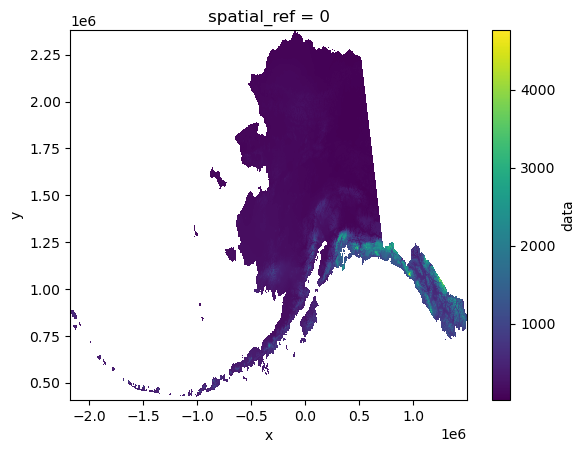

In [12]:
print(datasets[0].rio.crs)
datasets[0].data.plot()

EPSG:3338


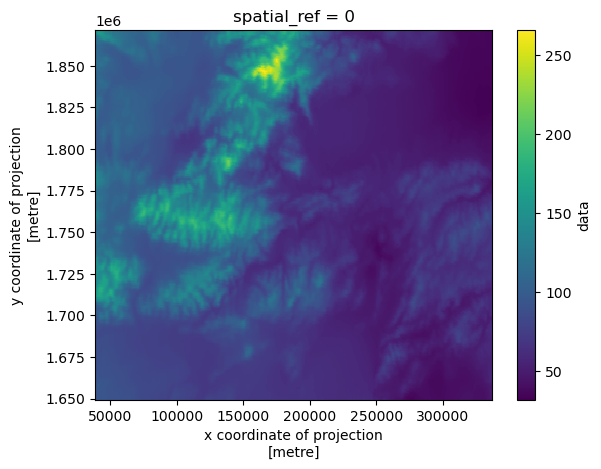

In [13]:
print(clipped_datasets[0].rio.crs)
clipped_datasets[0].data.plot()

EPSG:3338


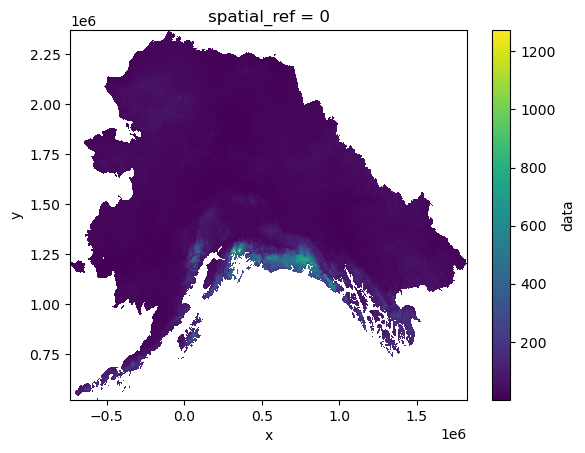

In [14]:
print(datasets[1].rio.crs)
datasets[1]["data"].plot()

EPSG:3338


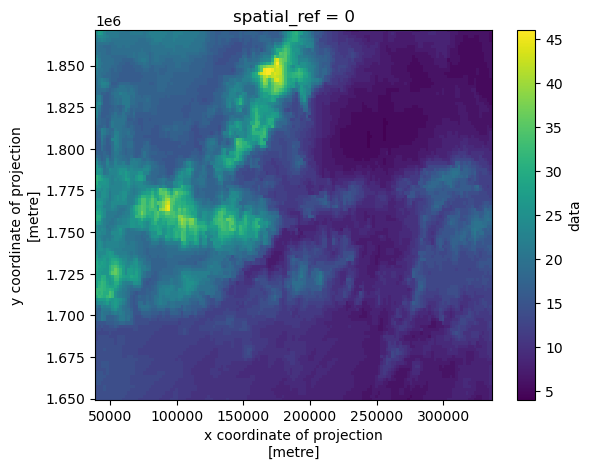

In [15]:
print(clipped_datasets[1].rio.crs)
clipped_datasets[1]["data"].plot()

EPSG:3338


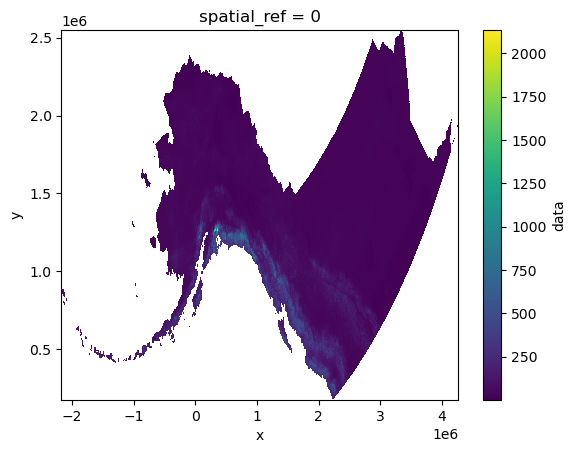

In [16]:
print(datasets[2].rio.crs)
datasets[2]["data"].plot()

EPSG:3338


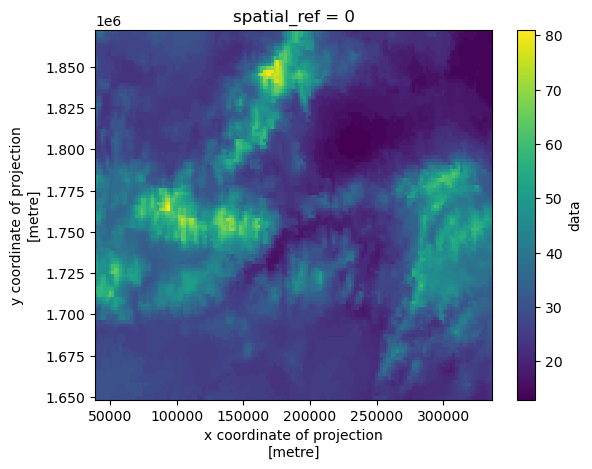

In [17]:
print(clipped_datasets[2].rio.crs)
clipped_datasets[2]["data"].plot()

EPSG:3338


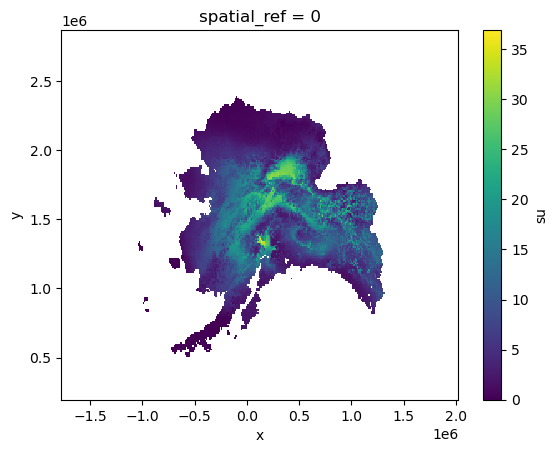

In [18]:
print(datasets[3].rio.crs)
datasets[3]["data"].plot()

EPSG:3338


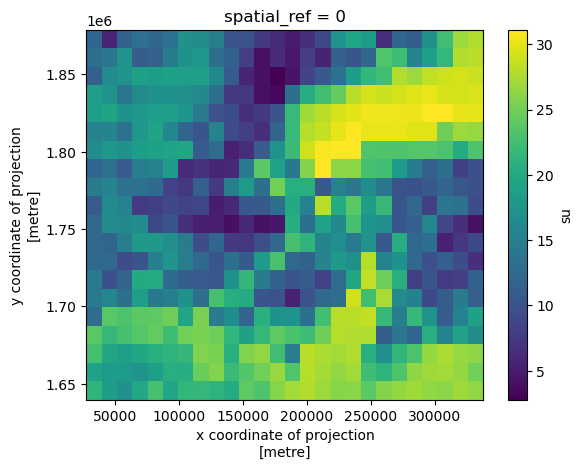

In [19]:
print(clipped_datasets[3]["data"].rio.crs)
clipped_datasets[3]["data"].plot()

EPSG:3338


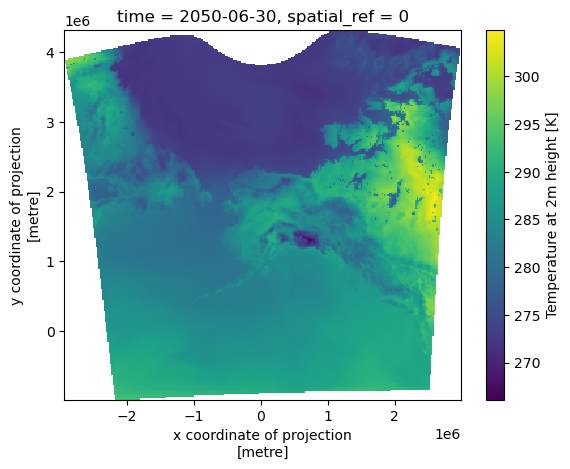

In [20]:
print(datasets[4].rio.crs)
datasets[4]["data"].plot()

EPSG:3338


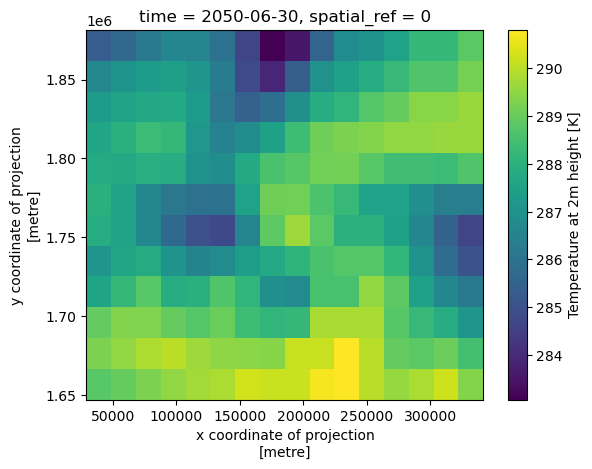

In [21]:
print(clipped_datasets[4]["data"].rio.crs)
clipped_datasets[4]["data"].plot()

In [37]:
# for each polygon, loop thru the clipped datasets and calculate the polygon area / grid cell area ratio
# use the ratio to determine the scale factor and calculate zonal stats
# use the results to populate a pandas dataframe with columns:
# polygon_id, polygon_area_km2, grid_name, grid_cell_area_km2, ratio, calculated_scale_factor, mean_at_scale_factor, mean_at_original_resolution

# create a list to store the result dicts
results = []

# loop thru the polygons
for polygon_id, polygon in polygons.items():
    # get the polygon area in km2
    polygon_area_km2 = polygon["area_km2"]
    # loop thru the clipped datasets
    for ds, grid_name, grid_size in zip(clipped_datasets, grid_names, grid_sizes):
        # get the grid cell area in km2
        grid_cell_area_km2 = (grid_size / 1000) ** 2
        # calculate the ratio of polygon area to grid cell area
        ratio = polygon_area_km2 / grid_cell_area_km2
        # determine the scale factor using the ratio in the hyperbolic function
        calculated_scale_factor = int(np.ceil(hyp_function(ratio, m, b, c, h)))
        scale_factors = [1, calculated_scale_factor]

        # interpolate the dataset and calculate the zonal stats for each scale factor
        means = []
        for scale_factor in scale_factors:

            print(
                f"Calculating zonal stats for {grid_name} at scale factor {scale_factor}"
            )

            interp_ds = interpolate_dataset(ds, "x", "y", scale_factor, "nearest")

            # if there are any NA values in the interpolated dataset, print a message
            # all datasets should be 100% populated, so this might indicate a problem with interpolation
            if interp_ds.isnull().any():
                print(f"NA values found in {grid_name} at scale factor {scale_factor}")

            poly_array = rasterize_polygon(interp_ds, "x", "y", polygon["gdf"])
            # if the poly_array does not contain any "1" values, print a message
            # this might indicate a problem with the rasterization, however this situation is not unexpected when
            # the polygon that is too small for the coarse grids; so we should only see this method for coarse grids and small scale factors
            if not np.any(poly_array):
                print(
                    f"Warning: rasterized polygon array for {polygon_id} is all zeros in {grid_name} at scale factor {scale_factor}"
                )

            zonal_stats = calculate_zonal_stats(interp_ds, poly_array)
            means.append(zonal_stats["mean"])

        # create the result dict
        result = {
            "polygon_id": polygon_id,
            "polygon_area_km2": polygon_area_km2,
            "grid_name": grid_name,
            "grid_cell_area_km2": grid_cell_area_km2,
            "ratio": ratio,
            "calculated_scale_factor": calculated_scale_factor,
            "mean_at_scale_factor": means[1],
            "mean_at_original_resolution": means[0],
            "difference": means[1] - means[0],
            "pct_difference": ((means[1] - means[0]) / means[0]) * 100,
        }

        # append the result dict to the results list
        results.append(result)

# create a pandas dataframe from the results list
df = pd.DataFrame(results)
df

Calculating zonal stats for 771m at scale factor 1
Calculating zonal stats for 771m at scale factor 2
Means for 771m: [82.06507258753203, 82.10381202527152]
Calculating zonal stats for 1km at scale factor 1
Calculating zonal stats for 1km at scale factor 2
Means for 1km: [13.963923444976077, 13.975746446627873]
Calculating zonal stats for 2km at scale factor 1
Calculating zonal stats for 2km at scale factor 2
Means for 2km: [30.983141762452107, 31.029439696106362]
Calculating zonal stats for 12km at scale factor 1
Calculating zonal stats for 12km at scale factor 5
Means for 12km: [15.22666670481364, 15.252414884940585]
Calculating zonal stats for 20km at scale factor 1
Calculating zonal stats for 20km at scale factor 8
Means for 20km: [287.9268003191267, 288.0126140133073]
Calculating zonal stats for 771m at scale factor 1
Calculating zonal stats for 771m at scale factor 2
Means for 771m: [82.81040086673889, 82.66711736073553]
Calculating zonal stats for 1km at scale factor 1
Calculati

,polygon_id,polygon_area_km2,grid_name,grid_cell_area_km2,ratio,calculated_scale_factor,mean_at_scale_factor,mean_at_original_resolution,difference,pct_difference
0,19080404,10440.947005,771m,0.594441,17564.311689,2,82.103812,82.065073,0.038739,0.047206
1,19080404,10440.947005,1km,1.000000,10440.947005,2,13.975746,13.963923,0.011823,0.084668
2,19080404,10440.947005,2km,4.000000,2610.236751,2,31.029440,30.983142,0.046298,0.149429
3,19080404,10440.947005,12km,144.000000,72.506576,5,15.252415,15.226667,0.025748,0.169099
4,19080404,10440.947005,20km,400.000000,26.102368,8,288.012614,287.926800,0.085814,0.029804
...,...,...,...,...,...,...,...,...,...,...
1760,190902010504,133.510321,771m,0.594441,224.598104,3,135.807199,135.629956,0.177243,0.130682
1761,190902010504,133.510321,1km,1.000000,133.510321,4,28.484665,28.436090,0.048575,0.170822
1762,190902010504,133.510321,2km,4.000000,33.377580,8,51.396218,51.114286,0.281932,0.551572
1763,190902010504,133.510321,12km,144.000000,0.927155,16,9.621591,9.100000,0.521591,5.731766


In [52]:
# sort results table by pct_difference and save df
df = df.sort_values(by="pct_difference", ascending=False)
df.to_csv("phase_2_results.csv", index=False)

In [38]:
# how many rows have NA values in the "mean_at_scale_factor" column? we should have values for all polygons
df[df["mean_at_scale_factor"].isna()]

,polygon_id,polygon_area_km2,grid_name,grid_cell_area_km2,ratio,calculated_scale_factor,mean_at_scale_factor,mean_at_original_resolution,difference,pct_difference


In [43]:
# how many rows have NA values in the "mean_at_original_resolution" column? only count the unique polygons
missed = df[df["mean_at_original_resolution"].isna()]["polygon_id"].unique()
# these are the polygons that are too small for the coarse grids and that would have been "missed" by the original zonal statistics method
print(
    f"Number of polygons missed by original zonal stats method: {len(missed)} out of {len(polygons)}"
)

Number of polygons missed by original zonal stats method: 236 out of 353


Text(0, 0.5, 'Count')

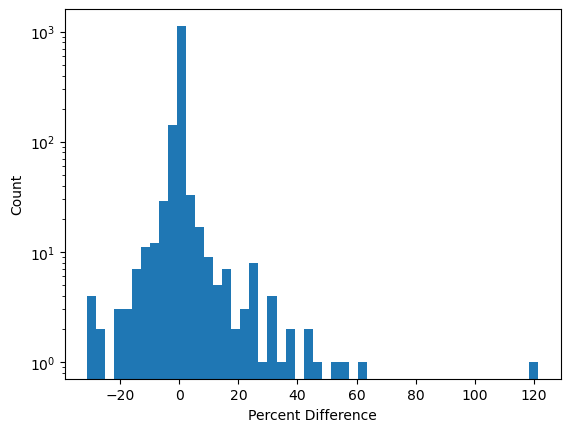

In [50]:
# plot the pct_difference between the means at the scale factor and the original resolution
# use a histogram, with log scale on the y axis
plt.hist(df["pct_difference"], bins=50)
plt.yscale("log")
plt.xlabel("Percent Difference")
plt.ylabel("Count")